# 3D classification example based on DenseNet

This tutorial shows an example of 3D classification task based on DenseNet and array format transforms.

Here, the task is given to classify MR images into male/female.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_classification/torch/densenet_training_array.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"


^C


## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

c:\Users\56991\anaconda3\envs\MONAI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No audio backend is available.


MONAI version: 1.0.0rc3
Numpy version: 1.21.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4a38e1150ab098811a0985d9f53327bc3f70e30c
MONAI __file__: c:\Users\56991\anaconda3\envs\MONAI\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.10.0
gdown version: 4.5.1
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
# Set data directory
os.environ["MONAI_DATA_DIRECTORY"] = "C:\\Users\\56991\\OneDrive\\PhD\\data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\56991\OneDrive\PhD\data


In [12]:
# IXI dataset as a demo, downloadable from https://brain-development.org/ixi-dataset/
images = [
    os.sep.join([root_dir, "ixi", "IXI314-IOP-0889-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI249-Guys-1072-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI609-HH-2600-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI173-HH-1590-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI020-Guys-0700-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI342-Guys-0909-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI134-Guys-0780-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI577-HH-2661-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI066-Guys-0731-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI130-HH-1528-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI607-Guys-1097-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI175-HH-1570-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI385-HH-2078-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI344-Guys-0905-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI409-Guys-0960-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI584-Guys-1129-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI253-HH-1694-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI092-HH-1436-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI574-IOP-1156-T1.nii.gz"]),
    os.sep.join([root_dir, "ixi", "IXI585-Guys-1130-T1.nii.gz"]),
]

# 2 binary labels for gender classification: man or woman
labels = np.array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=np.int64)

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [11]:
print(os.sep.join([root_dir, "ixi", "IXI314-IOP-0889-T1.nii.gz"]))
print(len(images))
print(labels.dtype)

C:\Users\56991\OneDrive\PhD\data\ixi\IXI314-IOP-0889-T1.nii.gz
20
int32


In [13]:
if not os.path.isfile(images[0]):
    resource = "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"
    md5 = "34901a0593b41dd19c1a1f746eac2d58"

    dataset_dir = os.path.join(root_dir, "ixi")
    tarfile_name = f"{dataset_dir}.tar"

    download_and_extract(resource, tarfile_name, dataset_dir, md5)

In [14]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

# Define nifti dataset, data loader
# import #images# #labels#
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=3, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:10], labels=labels[:10], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

<class 'monai.data.meta_tensor.MetaTensor'> (3, 1, 96, 96, 96) tensor([[1., 0.],
        [1., 0.],
        [1., 0.]]) torch.Size([3, 2])


In [15]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

loss_function = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/5
1/5, train_loss: 0.8971
2/5, train_loss: 0.6825
3/5, train_loss: 0.6055
4/5, train_loss: 0.7989
5/5, train_loss: 0.7718
epoch 1 average loss: 0.7511
----------
epoch 2/5
1/5, train_loss: 0.7103
2/5, train_loss: 0.5841
3/5, train_loss: 0.6843
4/5, train_loss: 0.5295
5/5, train_loss: 0.4094
epoch 2 average loss: 0.5835
saved new best metric model
Current epoch: 2 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
----------
epoch 3/5
1/5, train_loss: 0.3333
2/5, train_loss: 0.2667
3/5, train_loss: 0.8843
4/5, train_loss: 0.5878
5/5, train_loss: 1.7965
epoch 3 average loss: 0.7737
----------
epoch 4/5
1/5, train_loss: 0.8377
2/5, train_loss: 0.5007
3/5, train_loss: 0.6503
4/5, train_loss: 1.0695
5/5, train_loss: 0.4136
epoch 4 average loss: 0.6944
Current epoch: 4 current accuracy: 0.6000 
Best accuracy: 0.6000 at epoch 2
----------
epoch 5/5
1/5, train_loss: 0.4427
2/5, train_loss: 0.4469
3/5, train_loss: 0.4327
4/5, train_loss: 0.7045
5/5, train_loss: 0.5816

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [16]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [17]:
# Get a random image and its corresponding label
img, label = get_next_im()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 78.13it/s]


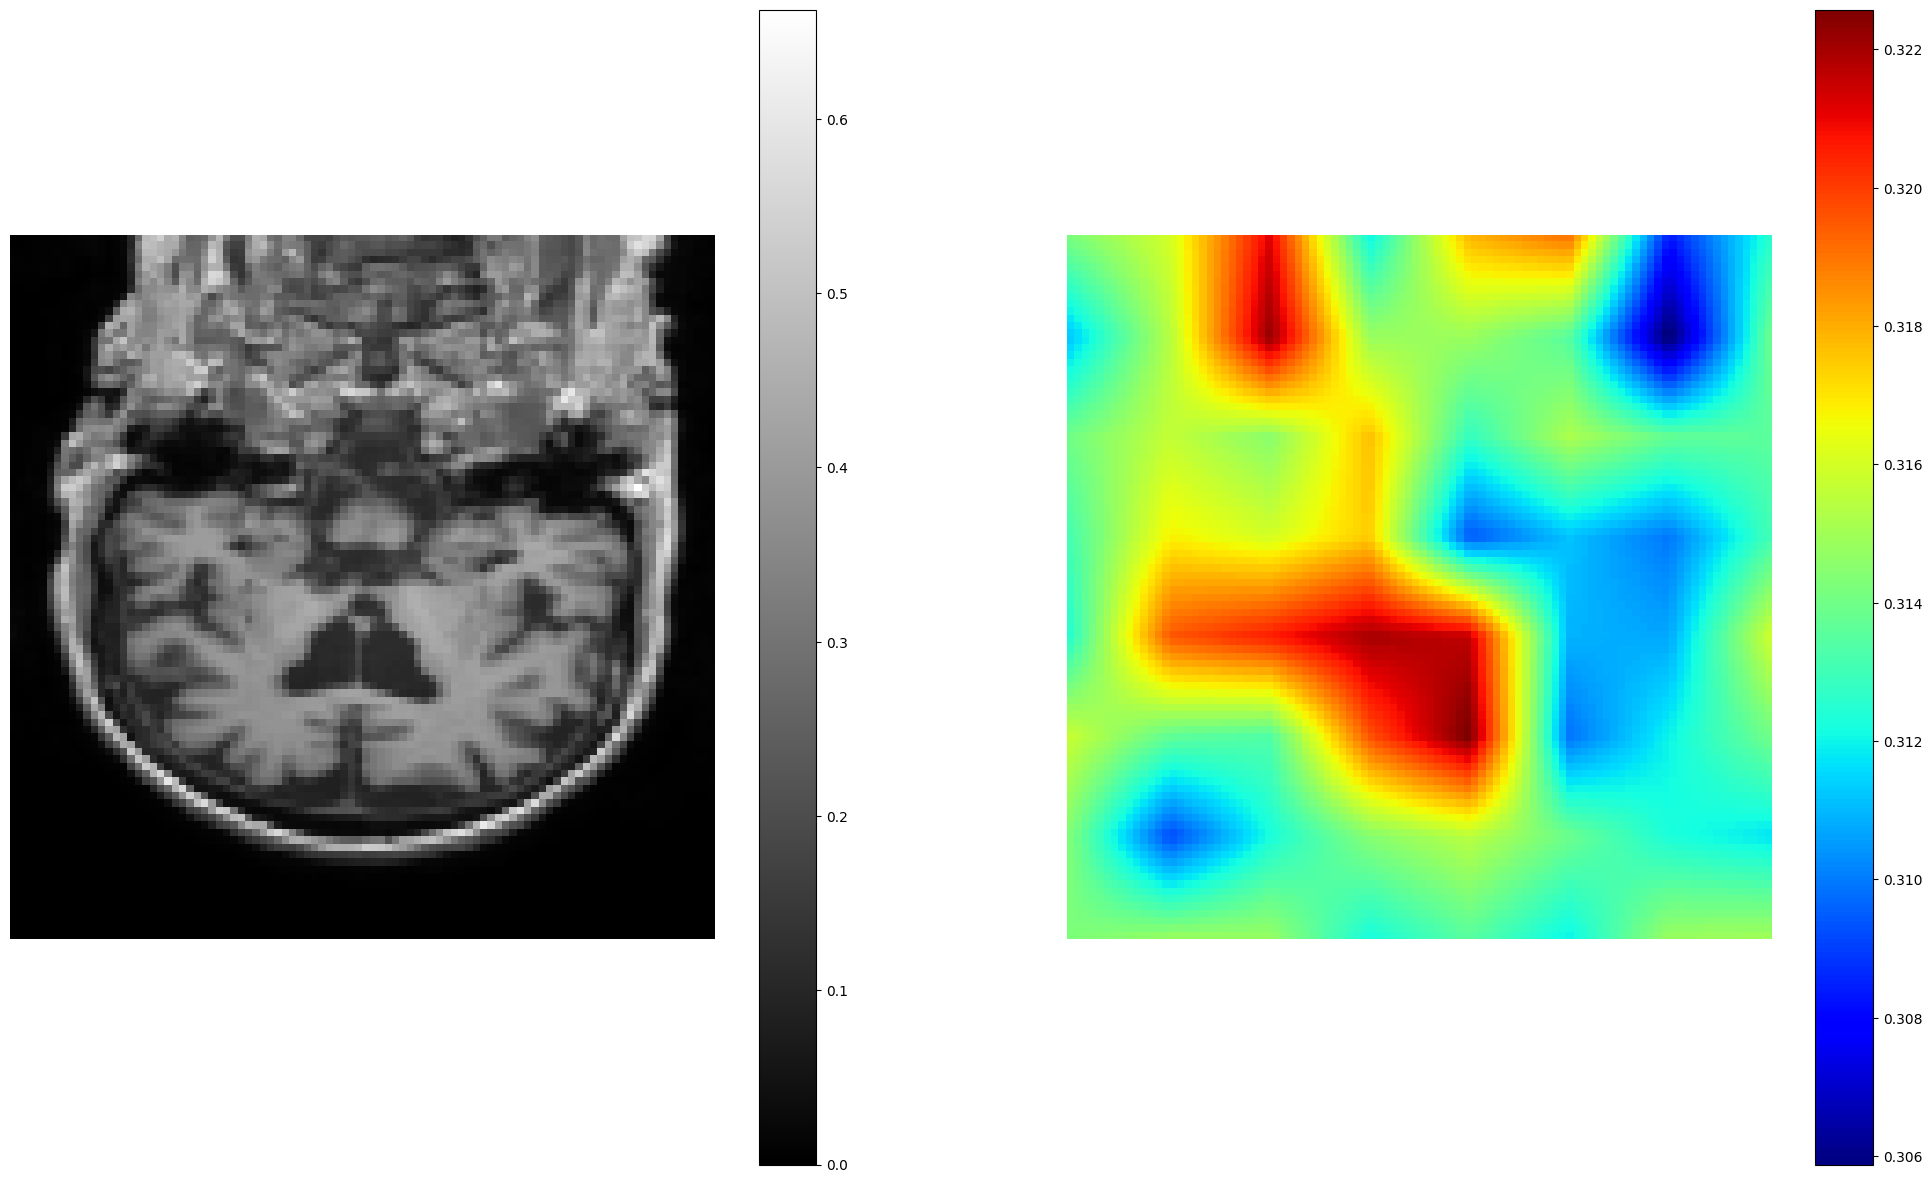

In [18]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.argmax().item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)